In [1]:
# import packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import transformers

In [2]:
# seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# configurations
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 10


## Load and Prepare Data

In [3]:
# transformations

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])



In [4]:
# load the dataset

full_trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
# get train-val split indices
targets = np.array(full_trainset.targets)
train_idx, val_idx = train_test_split(np.arange(len(targets)),
                                      test_size=0.2,
                                      stratify=targets,
                                      random_state=SEED)

# get val set base with test_tfms, split later
full_valset = datasets.CIFAR10(root="./data", train=True, download=True, transform=test_tfms)

# perform split using subset
train_ds = Subset(full_trainset, train_idx)
val_ds = Subset(full_valset, val_idx)

# Sanity check
print(f"Length of train_ds: {len(train_ds)} \t Length of val_ds: {len(val_ds)}")

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Length of train_ds: 40000 	 Length of val_ds: 10000


In [5]:
# dataloader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Create a Custom Model Class using ViT

In [6]:
from transformers import ViTForImageClassification
from PIL import Image
class CustomModel(nn.Module):

    def __init__(self, backbone_model='google/vit-base-patch16-224', num_cls=10, freeze_backbone=False):
        super().__init__()
        self.model = ViTForImageClassification.from_pretrained(backbone_model,
                                                               num_labels=num_cls,
                                                               problem_type="single_label_classification",
                                                               ignore_mismatched_sizes=True)
        if freeze_backbone:
            for name, p in self.model.named_parameters():
                if not name.startswith("classifier"):
                    p.requires_grad = False

    def forward(self, x, y):
        # will calculate loss internally and return multiple outputs
        return self.model(pixel_values=x, labels=y.long())

## Training Loop

In [7]:
def train_epoch(model, train_loader, optimizer, device, scaler=None, grad_clip=1.0):
    model.train()
    # save losses to plot later
    losses = []

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                out = model(features, labels)
                loss = out.loss
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()

        else:
            out = model(features, labels)
            loss = out.loss
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        losses.append(loss.item())
    return losses


## Evaluation Loop

In [8]:
def evaluate(model, val_loader, device):

    model.eval()

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        losses = []

        for feat, lab in val_loader:
            feat, lab = feat.to(device), lab.to(device)
            out = model(feat, lab)

            loss = out.loss
            losses.append(loss)

            logits = out.logits

            pred = torch.argmax(logits, dim=1)
            total_correct += (pred==lab).sum().item()
            total_samples += lab.size(0)
        accuracy = total_correct / total_samples * 100

    return losses, accuracy


## Training + Validation

In [9]:
def train_modelcv(train_loader, val_loader, model, device, optimizer, num_epochs, scaler=None):
    train_losses = []
    val_losses = []
    best_measure = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        train_loss = train_epoch(model, train_loader, optimizer, device, scaler)
        train_losses.append(train_loss)

        val_loss, measure = evaluate(model, val_loader, device)
        val_losses.append(val_loss)

        print(f"Performance measure: {measure}")

        if measure > best_measure:
            best_weights = model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print(f"Current best epoch: {best_epoch} with measure: {best_measure}")


    return best_weights, best_measure, best_epoch, train_losses, val_losses

In [10]:
# configurations

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))
model = CustomModel()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

/tmp/ipython-input-612268080.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
best_weights, best_measure, best_epoch, train_losses, val_losses = train_modelcv(train_loader,
                                                                                 val_loader,
                                                                                 model,
                                                                                 DEVICE,
                                                                                 optimizer,
                                                                                 EPOCHS,
                                                                                 scaler)


Epoch 1/10
----------


/tmp/ipython-input-2627081249.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Performance measure: 70.39
Current best epoch: 0 with measure: 70.39
Epoch 2/10
----------
Performance measure: 80.47999999999999
Current best epoch: 1 with measure: 80.47999999999999
Epoch 3/10
----------
Performance measure: 82.17
Current best epoch: 2 with measure: 82.17
Epoch 4/10
----------
Performance measure: 83.61
Current best epoch: 3 with measure: 83.61
Epoch 5/10
----------
Performance measure: 84.36
Current best epoch: 4 with measure: 84.36
Epoch 6/10
----------
Performance measure: 85.02
Current best epoch: 5 with measure: 85.02
Epoch 7/10
----------
Performance measure: 85.94000000000001
Current best epoch: 6 with measure: 85.94000000000001
Epoch 8/10
----------
Performance measure: 87.42
Current best epoch: 7 with measure: 87.42
Epoch 9/10
----------
Performance measure: 86.35000000000001
Epoch 10/10
----------
Performance measure: 87.86
Current best epoch: 9 with measure: 87.86


## Plot Results

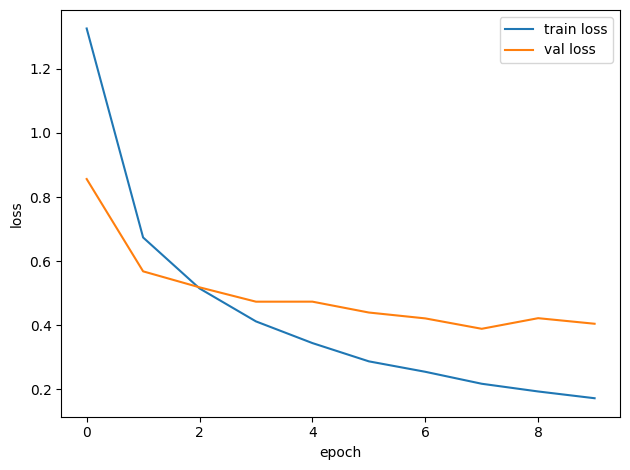

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def to_scalar(x):
    if isinstance(x, torch.Tensor):
        return float(x.detach().cpu().item())
    return float(x)

def epoch_mean(epoch_list):
    # epoch_list can be list of tensors/floats
    if len(epoch_list) == 0:
        return float("nan")
    # Faster/safer with torch when elements are tensors
    if isinstance(epoch_list[0], torch.Tensor):
        t = torch.stack([e.detach().cpu().float() for e in epoch_list])
        return float(t.mean().item())
    # otherwise assume floats
    return float(np.mean([to_scalar(e) for e in epoch_list]))

def plot_train_val_loss(train_losses, val_losses):
    # train_losses: List[List[Tensor or float]]
    # val_losses:   List[List[Tensor or float]] or List[float]
    t_losses = [epoch_mean(epoch) for epoch in train_losses]

    # val may be per-batch or already per-epoch
    if len(val_losses) > 0 and isinstance(val_losses[0], (list, tuple)):
        v_losses = [epoch_mean(epoch) for epoch in val_losses]
    else:
        v_losses = [to_scalar(e) for e in val_losses]

    plt.plot(t_losses, label="train loss")
    plt.plot(v_losses, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_train_val_loss(train_losses, val_losses)